In [1]:
!pip install git+https://github.com/StevenJokess/RL-Adventure-2
!git clone https://github.com/StevenJokess/RL-Adventure-2
%cd RL-Adventure-2
!ls

  Cloning https://github.com/StevenJokess/RL-Adventure-2 to /tmp/pip-req-build-56voypy5
  Running command git clone -q https://github.com/StevenJokess/RL-Adventure-2 /tmp/pip-req-build-56voypy5
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
fatal: destination path 'RL-Adventure-2' already exists and is not an empty directory.
/content/RL-Adventure-2
'1.actor-critic(colab).ipynb'   4.acer.ipynb		     9.her.ipynb
 1.actor-critic.ipynb	        5.ddpg.ipynb		     common
'2.gae(colab).ipynb'	        6.td3.ipynb		     README.md
 2.gae.ipynb		       '7.soft actor-critic.ipynb'
 3.ppo.ipynb		        8.gail.ipynb


In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [5]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [8]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [9]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [10]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
max_frames = 4000 #15000
frame_idx  = 0
test_rewards = []

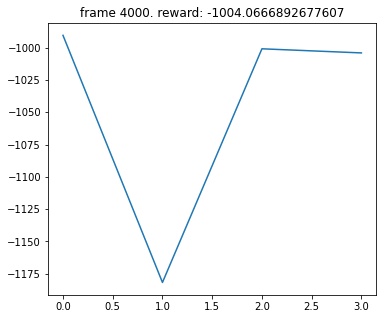

In [12]:
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

<h1>Saving trajectories for GAIL</h1>

In [13]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -1112.960701221157
episode: 1 reward: -1099.294586624267
episode: 2 reward: -1072.3373977836793
episode: 3 reward: -1050.8183438912797
episode: 4 reward: -776.7683648068127
episode: 5 reward: -862.731100080095
episode: 6 reward: -944.7533694225656
episode: 7 reward: -808.382836419688
episode: 8 reward: -747.32844265883
episode: 9 reward: -1057.0305006092685
episode: 10 reward: -965.6968636810801
episode: 11 reward: -1025.8448809037295
episode: 12 reward: -892.4005513182923
episode: 13 reward: -1209.8643579567552
episode: 14 reward: -864.4912306741742
episode: 15 reward: -1021.2137389358027
episode: 16 reward: -963.2342300872597
episode: 17 reward: -869.6196329870959
episode: 18 reward: -972.2461765410835
episode: 19 reward: -1016.9849153215393
episode: 20 reward: -1196.314071950579
episode: 21 reward: -1029.715352273832
episode: 22 reward: -1063.0013763595127
episode: 23 reward: -976.3640974600534
episode: 24 reward: -1484.776722920955
episode: 25 reward: -952.689555